In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)

def fig_panel_labels(axes, letters='ABCDEFGHIJKLMNOP', xcoord=-0.17, ycoord=0.92, panel_label_size=plt.rcParams[ 'axes.titlesize']*1.3):
    return [
        ax.annotate(letter, (xcoord, ycoord), xycoords='axes fraction', fontsize=panel_label_size)
        for ax, letter 
        in zip(axes.flat, letters)
    ]

## Definitions

- p: freq of ρ
- q: freq of Ρ
- x: freq of A within ρ
- 1-x: freq of B within ρ
- y: freq of A within Ρ
- 1-y: freq of B within Ρ

## Recursion 

$$
x' = \frac{x \omega_A ((1-\rho) x + \rho) + (1-x) \omega_B (1-\rho) x}{\bar{\omega}_{\rho}} \\
y' = \frac{y \omega_A ((1-P) y + P) + (1-y) \omega_B (1-P) y}{\bar{\omega}_{P}} \\ 
p' = p \frac{x \omega_A + (1-x) \omega_B}{\bar{\omega}} \\
q' = 1-p' = q \frac{y \omega_A + (1-y) \omega_B}{\bar{\omega}} \\
\bar{\omega} = p \bar{\omega_{\rho}}  + q \bar{\omega_{P}} \\
\bar{\omega_{\rho}} = x \omega_A + (1-x) \omega_B \\
\bar{\omega_{P}} = y \omega_A + (1-y) \omega_B
$$

# Modifier numerical simulation

In [2]:
def recursion(p, x, y, W, w, e, N=0):
    if np.random.rand() > e:
        W, w = w, W
   
    xx = (x * W * ((1 - ρ) * x + ρ) + 
          (1 - x) * w * (1 - ρ) * x) / (x * W + (1 - x) * w)
    yy = (y * W * ((1 - Ρ) * y + Ρ) + 
        (1 - y) * w * (1 - Ρ) * y) / (y * W + (1 - y) * w)

    q = 1 - p

    pp = p * (x * W + (1 - x) * w)
    meanW = pp + q * (y * W +  (1 - y) * w)
    pp /= meanW
    
    if N > 0:
        v = np.random.multinomial(N, [pp*xx, (1-pp)*yy, pp*(1-xx), (1-pp)*(1-yy)]) / N
        pp = v[0] + v[2]
        xx = v[0] / pp
        yy = v[1] / (1 - pp)        
    return pp, xx, yy

In [3]:
ρ = ρ0 = 0.1
Ρ = ρ/10
W = 1
w = 0.1
N = 0

n = 10000000
p = np.array([0.999]*n)
x = np.array([0.1]*n)
y = np.array([0.1]*n)
rate = np.array([0.0]*n)
rate[0] = p[0] * ρ + (1 - p[0]) * Ρ
invasions = []

for t in range(1, n):
    W, w = w, W
    p[t], x[t], y[t] = recursion(
        p[t-1], x[t-1], y[t-1], W, w, 1, N
    )
    rate[t] = p[t] * ρ + (1-p[t]) * Ρ
    if p[t] > 0.999:
        p[t] = 0.999 # mutator locus mutation
    if p[t] < 0.001:
        p[t] = 1-p[t]
        print(Ρ, end='')
        ρ, Ρ = Ρ, Ρ/10
        x[t] = y[t]
        invasions.append(t)
        
q = 1 - p

0.010.0010.00011e-051.0000000000000002e-06

In [4]:
for i, inv in enumerate(invasions):
    print(i, ρ0/(10**(i+1)))

0 0.01
1 0.001
2 0.0001
3 1e-05
4 1e-06


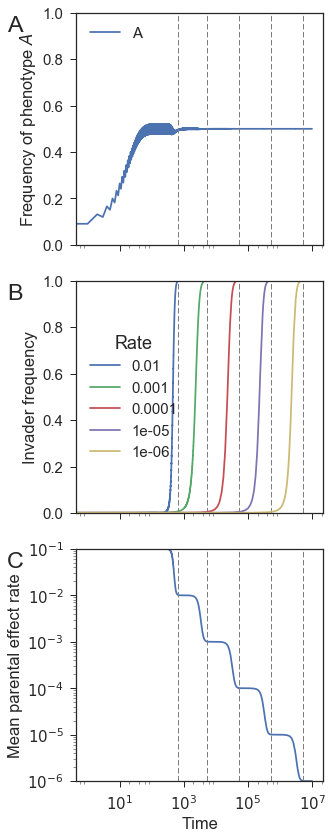

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(5, 12), sharey=False, sharex=True)
axes[0].plot(p*x + q*y, label='A')
# axes[0].axhline(e, ls='--', color='gray')
axes[2].plot(rate)
t = 0
for i, inv in enumerate(invasions):
    for j in range(3): axes[j].axvline(inv, ls='--', lw=1, color='gray')
    axes[1].plot(q[t:inv], label='{:.2g}'.format(ρ0/(10**(i+1))))
    t = inv
axes[0].set(ylim=(0,1), ylabel='Frequency of phenotype $A$')
axes[0].legend()
axes[1].set(ylim=(0,1), ylabel='Invader frequency')
axes[1].legend(title='Rate')
axes[2].set(ylabel='Mean parental effect rate', yscale='log', xlabel='Time', xscale='log', ylim=(rate.min(), rate.max()))

fig_panel_labels(axes, xcoord=-0.28)
fig.tight_layout()

fig.savefig('../figures/A1B1_modifier_invasions.pdf')

# Modifier analysis

In [10]:
import sympy
sympy.init_printing()

In [11]:
x, s, ρ, Ρ, ε = sympy.symbols('x s ρ Ρ ε', real=True, positive=True)

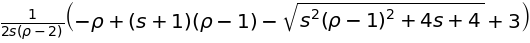

In [12]:
x_star = ((1 + s) * (1 - ρ) - (3 - ρ) + sympy.sqrt((1 - ρ)**2 * s**2 + 4 * (1 + s))) / (2 * (2 -  ρ) * s)
x_star = sympy.simplify(x_star)
x_star

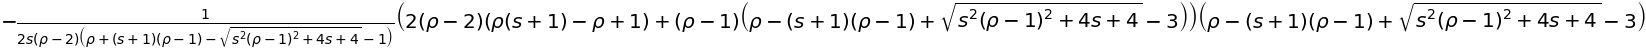

In [13]:
x_star_prime = x_star * (x_star * (1 - ρ) * s + ρ * (1 + s) + (1 - ρ)) / (1 + s * x_star)
x_star_prime = sympy.simplify(x_star_prime)
x_star_prime

In [14]:
x_star_eta_0 = 1/(4*s) * (s + (s+2) -2)
x_star_eta_0

In [15]:
x_star = x_star_eta_0

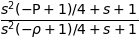

In [16]:
λ = (1 + s + s**2 * (1 - Ρ) * x_star * (1 - x_star)) / (1 + s + s**2 * (1 - ρ) * x_star * (1 - x_star))
λ

In [17]:
# Mean fitness

s_ = np.linspace(0, 1, 100)
ρ_ = np.linspace(0, 1, 100).reshape(100, 1)

ww = (s_ * (1 - ρ_) - 2 + np.sqrt((1 - ρ_)**2 * s_**2 + 4*(1 + s_))) / (2 * (2 - ρ_))

In [21]:
λ_ = np.array(
    [
        [
            float(λ.subs({ρ: 0, Ρ: H_, s: s_})) 
            for s_ in np.linspace(0, 1, 100)
        ] 
        for H_ in np.linspace(0, 1 , 100)
    ]
)

λ_.min(), λ_.max(), (λ_ >= 1).all(), (λ_ <= 1).all()

(0.88888888888888884, 1.0, False, True)

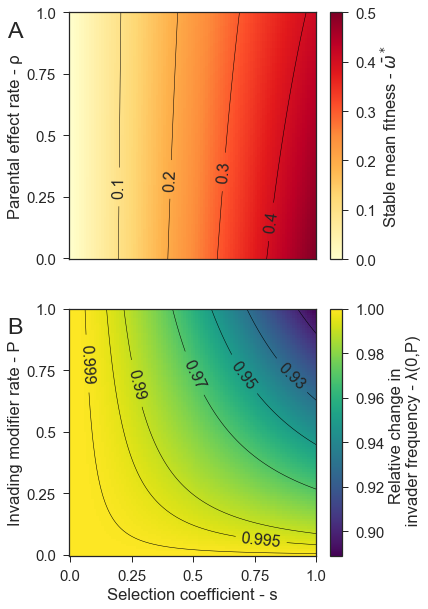

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

ax = axes[0]
extent = (-0.5, ww.shape[0], -0.5, ww.shape[1])
im = ax.imshow(ww, cmap='YlOrRd', origin=(0,0), aspect=1, extent=extent, interpolation='none')
cntr = ax.contour(ww, levels=np.linspace(0.1, 0.4, 4), aspect=1, linewidths=0.5, colors='k', extent=extent)
ax.clabel(cntr, fmt=lambda x: '{:.1f}'.format(x), fontsize=16, colors="#252525")
cb1 = plt.colorbar(im, ax=ax, fraction=0.045, label=r'Stable mean fitness - $\bar{\omega}^*$')
# ax.set_xlabel('Selection coefficient - s')
ylabel1 = ax.set_ylabel(r'Parental effect rate - ρ')
ax.set_xticks([])
# ax.set_xticklabels(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(0, 100, 5))
ax.set_yticklabels(np.linspace(0, 1, 5))

ax = axes[1]
extent = (-0.5, λ_.shape[0], -0.5, λ_.shape[1])
im = ax.imshow(λ_, cmap='viridis', origin=(0,0), aspect=1, extent=extent, interpolation='none')
cntr = ax.contour(λ_, levels=[0.9, 0.93, 0.95, 0.97, 0.99, 0.995, 0.999], aspect=1, linewidths=0.5, colors='k', extent=extent)
ax.clabel(cntr, fmt=lambda x: '{:.3g}'.format(x),fontsize=16, colors="#252525")
# ax.set_xlabel('Selection coefficient - s')
ylabel2 = ax.set_ylabel('Invading modifier rate - Ρ')
cb2 = plt.colorbar(im, ax=ax, fraction=0.045, label="Relative change in \n invader frequency - λ(0,Ρ)")
ax.set_xticks(np.linspace(0, 100, 5))
ax.set_xticklabels(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(0, 100, 5))
ax.set_yticklabels(np.linspace(0, 1, 5))

axes[1].set_xlabel('Selection coefficient - s')
fig_panel_labels(axes, xcoord=-0.25, ycoord=0.9)
# fig.tight_layout()

txt = [ylabel1, ylabel2]
fig.savefig('../figures/A1B1_EGS_eta_0.pdf', bbox_inches='tight')#, bbox_extra_artists=txt)
# txt